In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ish_parser import ish_parser
from datetime import datetime, timedelta
import math
import random
from IPython.display import clear_output

In [2]:
def read_ish_file (file_path):
    wf = ish_parser()

    with open(file_path) as fp:
        file_content = fp.read()
        wf.loads(file_content)

    all_station_observations = []
    for report in wf.get_observations():
        all_station_observations.append(report)

    return all_station_observations

def get_every_hour_of_year_iso(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31, 23)

    current_date = start_date
    timestamps = []

    while current_date <= end_date:
        timestamps.append(current_date.isoformat())
        current_date += timedelta(hours=1)

    return timestamps

def save_divide(n, d):
    if d == 0:
        return None
    
    return n / d

In [3]:
def year_periodic_function(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")

    day_of_year = date_obj.timetuple().tm_yday

    phase_shift = math.pi / 2

    sin_value = math.sin((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    sin_function = 1 - (sin_value + 1) / 2

    cos_value = math.cos((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    cos_function = 1 - (cos_value + 1) / 2

    return sin_function, cos_function

def point_on_unit_circle(degrees):
    radians = math.radians(degrees)
    x = 0.5*math.cos(radians)+0.5
    y = 0.5*math.sin(radians)+0.5
    return (x, y)

class ManyObservationAggregator:
    def __init__(self, observations, year, name):
        self.observations = observations
        self.year = year
        self.name = name
        self.hours_of_year = get_every_hour_of_year_iso(self.year)
        self.grouped_observations = self.group_observations_by_hour()
        self.rows = self.get_all_rows()

    def get_metric(self, metric_key, rolling_on=False):
        res = []
        for i in range(len(self.rows)):
            val = self.rows[i][metric_key]
            prev = val

            if rolling_on and len(res):
                prev = res[i-1]

            rolling = 0.6*(val) + 0.4 * (prev)

            res.append(rolling)

        return res

    # we group all of the observations for each hour since there may be more than observation per hour
    def group_observations_by_hour(self):
        hour_mapping = dict()
        for hour in self.hours_of_year:
            hour_mapping[hour[0:13]] = []

        for observation in self.observations:
            hour = observation.datetime.isoformat()[0:13]
            if hour in hour_mapping:
                hour_mapping[hour].append(observation)

        return hour_mapping
    
    def get_all_rows(self):
        rows = []
        for i in range(len(self.hours_of_year)):
            rows.append(self.get_row(i, rows))

        return rows
    
    def get_row(self, i, rows):
        hour = self.hours_of_year[i]
        observations_in_hour = self.grouped_observations[hour[0:13]]
        agg_observations_in_hour = self.group_list_of_observations(observations_in_hour, hour)

        # fill in missing values as the previous values
        for key, value in agg_observations_in_hour.items():
            if value is None:
                if i != 0 :
                    agg_observations_in_hour[key] = rows[i - 1][key]
                else:
                    agg_observations_in_hour[key] = 0

        return agg_observations_in_hour


    # we aggergate the datapoints in each hour window
    def group_list_of_observations(self, observations_in_hour, date):
        total_temp = 0
        num_temp = 0

        total_wind_speed = 0
        num_wind_speed = 0

        total_sky_cover = 0
        num_sky_cover = 0

        total_wind_direction = 0
        num_wind_direction = 0

        total_dew_point = 0
        num_dew_point = 0

        total_pressure = 0
        num_pressure = 0

        total_vis = 0
        num_vis = 0

        total_precipitation = 0
        num_precipitation = 0

        station = ""

        hour_of_day = float(date[11:13])
        t_sin = 0.5*math.sin(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_cos = 0.5*math.cos(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_sin_year, t_cos_year = year_periodic_function(date[0:10])
        has = 0

        for observation in observations_in_hour:
            station = observation.weather_station
            # we know that there is always temperature in an observation, as it is required
            if observation.air_temperature is not None and observation.air_temperature.get_fahrenheit() != "MISSING":
                total_temp += float(observation.air_temperature.get_fahrenheit())
                num_temp += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.sky_cover is not None and str(observation.sky_cover[0]["coverage"]) !=  "MISSING" and len(observation.sky_cover) > 0:
                # todo there is an observation here for each cloud type, we may want to do something
                total_sky_cover += float(str(observation.sky_cover[0]["coverage"]))
                num_sky_cover += 1

            if observation.visibility_distance is not None and str(observation.visibility_distance) !=  "MISSING":
                # todo there is an observation here for each cloud type, we may want to do something
                v = float(str(observation.visibility_distance.get_miles()))
                total_vis += float(v)
                num_vis += 1

            if observation.wind_direction is not None and str(observation.wind_direction) != "MISSING":
                total_wind_direction += float(str(observation.wind_direction))
                num_wind_direction += 1

            if observation.dew_point is not None and observation.dew_point.get_fahrenheit() != "MISSING":
                total_dew_point += float(observation.dew_point.get_fahrenheit())
                num_dew_point += 1

            if observation.sea_level_pressure is not None and str(observation.sea_level_pressure) != "MISSING":
                total_pressure += float(str(observation.sea_level_pressure))
                num_pressure += 1

            if observation.precipitation is not None and str(observation.precipitation) !=  "MISSING" and len(observation.precipitation) > 0:
                num = float(str(observation.precipitation[0]["depth"]))
                if num < 500:
                    total_precipitation += float(str(observation.precipitation[0]["depth"]))
                    num_precipitation += 1


        wind_direction_sin = None
        wind_direction_cos = None

        if num_wind_direction > 0:
            wind_direction_sin, wind_direction_cos = point_on_unit_circle(total_wind_direction / num_wind_direction)

        return {
            "station": station,
            "air_temp": save_divide(total_temp, num_temp),
            "wind_speed": save_divide(total_wind_speed, num_wind_speed),
            "sky_coverage": save_divide(total_sky_cover, num_sky_cover),
            "dew_point": save_divide(total_dew_point, num_dew_point),
            "pressure": save_divide(total_pressure, num_pressure),
            "vis": save_divide(total_vis, num_vis),
            "precip": save_divide(total_precipitation, num_precipitation),
            "wind_direction_sin": wind_direction_sin,
            "wind_direction_cos": wind_direction_cos,
            "t_sin": t_sin,
            "t_cos": t_cos,
            "t_sin_year": t_sin_year,
            "t_cos_year": t_cos_year,
        }


In [4]:
years = ["2018","2019","2020", "2021", "2022", "2023"]
stations = {
    "lax": "722950-23174",
    "lan": "723820-23182",
    "san": "722900-23188",
    "cat": "722920-23191",
    "pam": "722868-93138"
}

all_weather = {}

for (place, station_id) in stations.items():
    all_weather[place] = {}

    for year in years:
        observations = read_ish_file(f"./data/{station_id}-{year}")
        # print(f"/Users/carterharrison/Desktop/weather/{year}/{station_id}-{year}")
        all_weather[place][year] = ManyObservationAggregator(observations, int(year), place)

In [117]:
def get_group_metric(place, years, metric):
    running = []

    for year in years:
        running = running + all_weather[place][year].get_metric(metric)

    return running

def norm(x):
    mean = np.mean(x)
    std = np.std(x)
    s = (x - mean)/std
    
    max = np.max(s)
    min = np.min(s)

    return (s-min)/(max-min)

def denorm(all, x):
    mean = np.mean(all)
    std = np.std(all)
    s = (all - mean)/std
    max = np.max(s)
    min = np.min(s)
    mid = ((x * (max-min)) + min)
    return (mid*std) + mean

def window_array(array, window_length) -> list:
    """Split a 2D array into list of non-overlapping windows along the first (usu time) axis, 
    discarding remainder."""
    num_windows = len(array) // window_length
    windows = [array[i*window_length:(i+1)*window_length] for i in range(num_windows)]
    return windows

In [129]:
class LSTMPreProcess:
    def __init__(self, input_metrics, output_metrics, train_years, validation_years, test_years):
        self.train_years, self.validation_years = train_years, validation_years
        self.input_metrics, self.output_metrics = input_metrics, output_metrics
        self.test_years = test_years
        self.in_window_length = input_metrics[0][2] # assume same for all features
        self.out_window_length = output_metrics[0][2] # assume same for all features

        self.train_X = None
        self.train_Y = None
        self.full_train_Y = None
        self.validation_X = None
        self.validation_Y = None
        self.full_validation_Y = None
        self.test_X = None
        self.test_Y = None
        self.full_test_Y = None # vals corresponding to test_X and in test_Y future

    def get_year_data_with_window(self, years, metrics, n_inputs):
        res  = []
        for j, metric in enumerate(metrics):
            place = metric[0]
            key = metric[1]
            window_size = metric[2]
            data = get_group_metric(place, years, key)
            if j < n_inputs:
                data = norm(data)
            res.append((data, window_size))
        return res
    
    def get_training_data(self):
        self.train_X, self.train_Y, self.full_train_Y = self.transform_data(self.train_years)
    
    def get_validation_data(self):
        self.validation_X, self.validation_Y, self.full_validation_Y = self.transform_data(self.validation_years)

    def get_test_data(self):
        self.test_X, self.test_Y, self.full_test_Y = self.transform_data(self.test_years)
    
    def transform_data(self, years):
        data_by_metric = self.get_year_data_with_window(years, self.input_metrics+self.output_metrics, len(self.input_metrics))
        
        windows_by_metric = [window_array(metric[0], self.in_window_length+self.out_window_length) for metric in data_by_metric]

        windowed_metrics = np.transpose(np.array(windows_by_metric)).swapaxes(0,1)
        inputs_by_metric = windowed_metrics[:, :self.in_window_length, :len(self.input_metrics)]
        outputs_by_metric = windowed_metrics[:, self.in_window_length:, len(self.input_metrics):]
        full_outputs_by_metric = windowed_metrics[:, :, len(self.input_metrics):]

        return inputs_by_metric, outputs_by_metric, full_outputs_by_metric

        # windowed_inputs_by_metric = [window_array(input[0], self.in_window_length) for input in inputs_by_metric]
        # windowed_outputs_by_metric = [window_array(output[0], self.in_window_length+self.out_window_length) for output in full_outputs_by_metric]

        # pairs = list(zip(windowed_inputs_by_metric, windowed_outputs_by_metric))
        # random.shuffle(pairs)
        # shuffled_inputs, shuffled_outputs = zip(*pairs)

        # orged_x = np.transpose(list(shuffled_inputs)).swapaxes(0,1)
        # orged_y = np.transpose(list(shuffled_outputs)).swapaxes(0,1)

        # return orged_x, orged_y


In [149]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            axs[i].set_xlabel("Epoch")
            axs[i].set_ylabel("Error")
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                axs[i].set_xlabel("Epoch")
                axs[i].set_ylabel("Error")
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
class WeatherPredictor:
    def __init__(self, in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size):
        self.epochs = epochs
        self.in_window_len = in_window_len
        self.out_window_len = out_window_len
        self.n_features_in = n_features_in
        self.n_features_out = n_features_out
        self.batch_size = batch_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(self.in_window_len, self.n_features_in), 
                                 return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            tf.keras.layers.LSTM(100, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00006)),
            # tf.keras.layers.Dense(4*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dense(2*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.out_window_len*self.n_features_out)
        ])
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def train(self, train_X, train_Y, validation_X, validation_Y):
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        self.model.fit(np.array(train_X), np.array(train_Y), validation_data=(validation_X, validation_Y), 
                       epochs=self.epochs, batch_size=self.batch_size, callbacks=[callback, PlotLearning()])
        
    def evaluate(self, X_test, Y_test):
        mse, mae = self.model.evaluate(X_test, Y_test)
        print(f"MAE of test data (in degrees F): {mae}")

    def plot_predictions_at_random_point(self, X_test, Y_test, Y_full_true):
        Y_true = Y_full_true
        Y_pred = self.model.predict(X_test)

        rand_inds = random.sample(range(Y_pred.shape[0]), 3)

        for ind in rand_inds:
            prediction = Y_pred[ind]
            truth = Y_true[ind]
            real_x = np.arange(0, len(truth))
            predicted_x = len(truth) - len(prediction) + np.arange(0, len(prediction)) 

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, prediction, label="Prediction", color="green")
            plt.plot(real_x, truth, label="Truth")

            plt.axvline(len(truth)-len(prediction), color="red")
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

In [161]:
train_years = ["2018", "2019", "2020", "2021"]
validation_years = ["2022"]
test_years = ["2023"]
given_window_length = 72
predicting_window_length = 24

DataClass = LSTMPreProcess([
    ("lax", "air_temp", given_window_length),
    ("lax", "wind_speed", given_window_length),
    ("lax", "sky_coverage", given_window_length),
    ("lax", "dew_point", given_window_length),
    ("lax", "pressure", given_window_length),
    ("lax", "vis", given_window_length),
    ("lax", "wind_direction_sin", given_window_length),
    ("lax", "wind_direction_cos", given_window_length),
    ("lax", "precip", given_window_length),

    ("lax", "t_sin", given_window_length),
    ("lax", "t_cos", given_window_length),
    ("lax", "t_sin_year", given_window_length),
    ("lax", "t_cos_year", given_window_length)],
    [("lax", "air_temp", predicting_window_length)
], train_years, validation_years, test_years)
DataClass.get_training_data()
DataClass.get_validation_data()
DataClass.get_test_data()

In [172]:
print(DataClass.train_X.shape)
print(DataClass.train_Y.shape)
print(DataClass.full_train_Y.shape)

(365, 72, 13)
(365, 24, 1)
(365, 96, 1)


In [173]:
in_window_len = DataClass.train_X.shape[1]
out_window_len = DataClass.train_Y.shape[1]
n_features_in = DataClass.train_X.shape[2]
n_features_out = DataClass.train_Y.shape[2]
epochs = 300
batch_size = 32

Predictor = WeatherPredictor(in_window_len, out_window_len, n_features_in, n_features_out, epochs, batch_size)

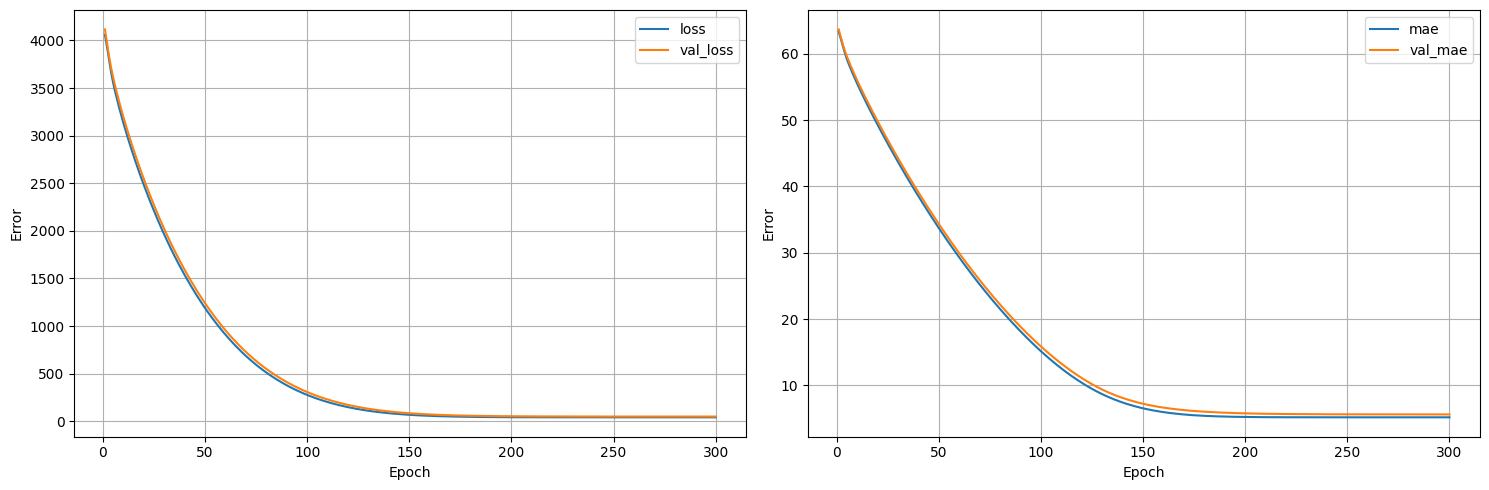

12/12 [==============================] - 1s 84ms/step - loss: 41.2246 - mae: 5.1918 - val_loss: 49.1518 - val_mae: 5.6268


In [174]:
Predictor.train(DataClass.train_X, DataClass.train_Y, DataClass.validation_X, DataClass.validation_Y)

In [175]:
Predictor.evaluate(DataClass.test_X, DataClass.test_Y)

3/3 [==============================] - 0s 19ms/step - loss: 39.4709 - mae: 5.1570
MAE of test data (in degrees F): 5.156952381134033


3/3 [==============================] - 0s 19ms/step


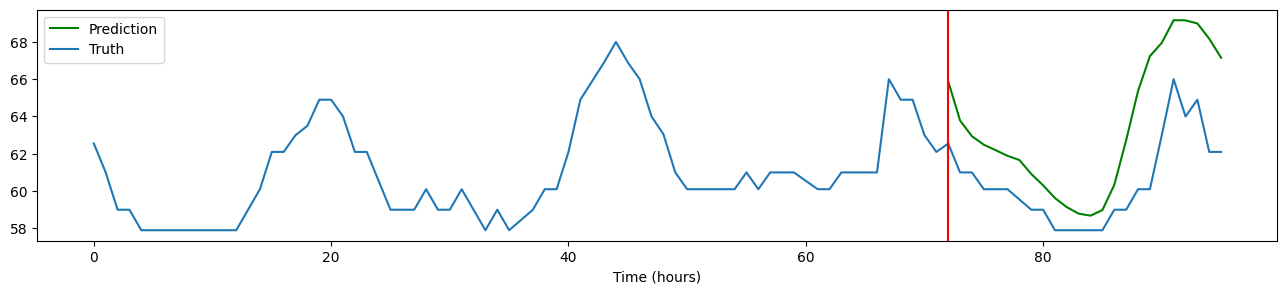

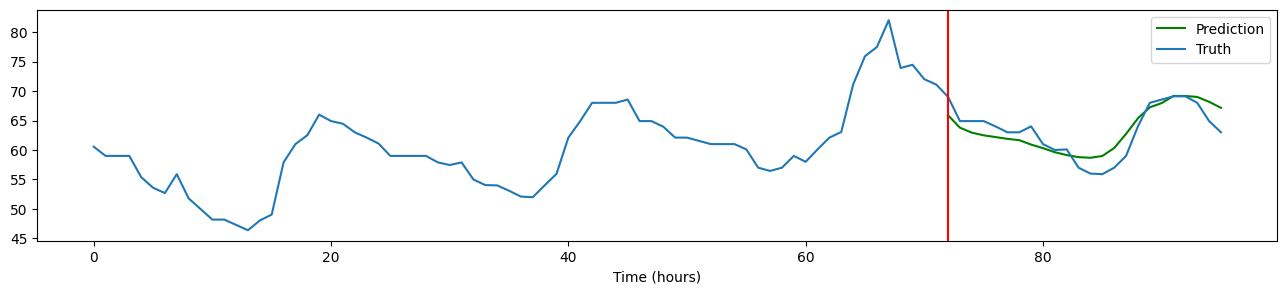

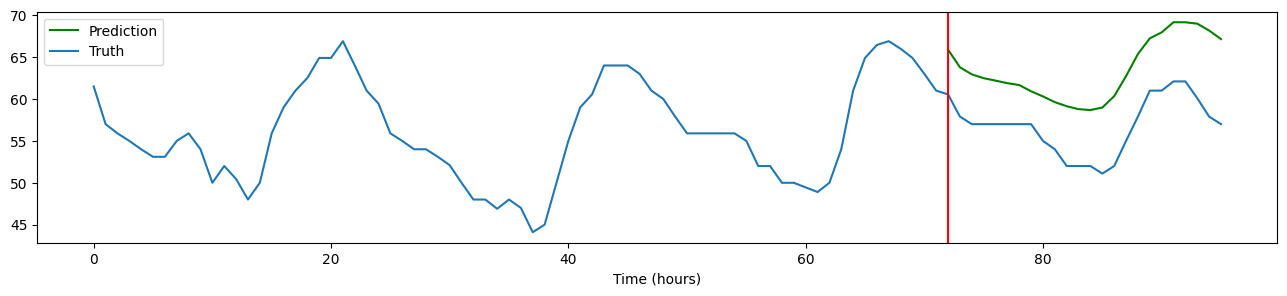

<Figure size 1600x300 with 0 Axes>

In [178]:
Predictor.plot_predictions_at_random_point(DataClass.test_X, DataClass.test_Y, DataClass.full_test_Y)